In [8]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights_dict)

# Initialize models with regularization + balance
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=6, class_weight=class_weights_dict, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=7, class_weight=class_weights_dict, random_state=42),
    "XGBoost": XGBClassifier(
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.5,
        scale_pos_weight=class_weights_dict[1]/class_weights_dict[0],
        learning_rate=0.1,
        n_estimators=150,
        random_state=42
    ),
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), alpha=0.001, max_iter=300, random_state=42)
}

# Train and evaluate
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


Class Weights: {0: np.float64(8.267784348624907), 1: np.float64(0.5321842096510128)}

Training Decision Tree...
Decision Tree Accuracy: 0.9175
              precision    recall  f1-score   support

           0       0.42      0.97      0.59      4354
           1       1.00      0.91      0.95     67646

    accuracy                           0.92     72000
   macro avg       0.71      0.94      0.77     72000
weighted avg       0.96      0.92      0.93     72000

------------------------------------------------------------

Training Random Forest...
Random Forest Accuracy: 0.9166
              precision    recall  f1-score   support

           0       0.42      0.98      0.59      4354
           1       1.00      0.91      0.95     67646

    accuracy                           0.92     72000
   macro avg       0.71      0.94      0.77     72000
weighted avg       0.96      0.92      0.93     72000

------------------------------------------------------------

Training XGBoost...
XG

In [25]:
train_pred = model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, train_pred))


Training Accuracy: 0.9573020833333333


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.005],
    'max_iter': [500]
}

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'lbfgs'}
Best Accuracy: 0.9577291666666667


In [27]:
best_mlp = MLPClassifier(
    activation='tanh',
    alpha=0.0001,
    hidden_layer_sizes=(50,),
    learning_rate_init=0.001,
    max_iter=500,
    solver='lbfgs',
    random_state=42
)

best_mlp.fit(X_train, y_train)


MLPClassifier(activation='tanh', hidden_layer_sizes=(50,), max_iter=500,
              random_state=42, solver='lbfgs')

Test Accuracy: 0.9574027777777778

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.68      0.66      4354
           1       0.98      0.98      0.98     67646

    accuracy                           0.96     72000
   macro avg       0.81      0.83      0.82     72000
weighted avg       0.96      0.96      0.96     72000



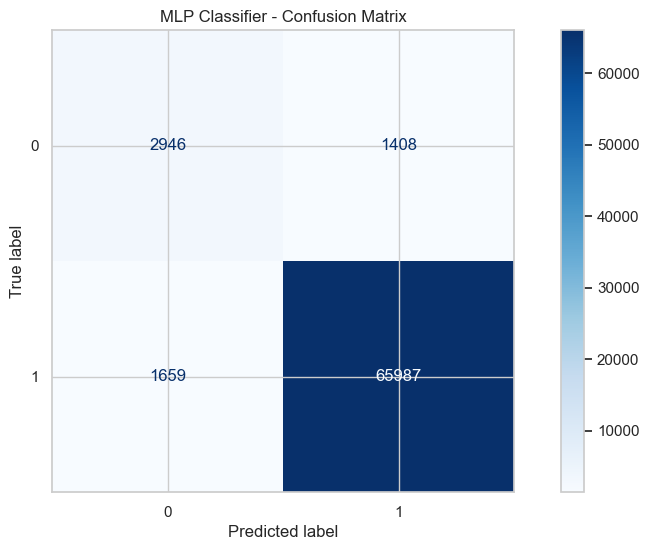

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_mlp.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("MLP Classifier - Confusion Matrix")
plt.show()


In [30]:
from sklearn.inspection import permutation_importance

r = permutation_importance(best_mlp, X_test, y_test, n_repeats=10, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]}: {r.importances_mean[i]:.4f}")


Cash_to_Expense: 0.0750
Profit_Margin: 0.0004
Revenue_per_Employee: 0.0002
Sub_Sector: 0.0002
Industry: 0.0001


In [36]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_mlp, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Std Dev CV Accuracy:", np.std(cv_scores))

Cross-Validation Accuracy Scores: [0.95734722 0.95840278 0.95723611 0.95697222 0.95781944]
Mean CV Accuracy: 0.9575555555555555
Std Dev CV Accuracy: 0.0005046083923496022


In [86]:
import joblib

joblib.dump(best_mlp, "mlp_model.pkl")

joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [96]:
# Get predicted probability of being at risk
prob = best_mlp.predict_proba(X_test)[:,1]  # probability for class 1

# Convert to a business health score (0-100)
business_score = (1 - prob) * 100  # higher score = healthier


In [97]:
def generate_alert(prob):
    if prob > 0.7:
        return "⚠️ High Risk: Business at risk next month"
    elif prob > 0.4:
        return "⚠️ Moderate Risk: Monitor closely"
    else:
        return "✅ Low Risk: Business healthy"

alerts = [generate_alert(p) for p in prob]


In [93]:
import pandas as pd
import numpy as np
import joblib  # for loading saved models/scalers

# Load model and scaler
mlp_model = joblib.load('mlp_model.pkl')
scaler = joblib.load('scaler.pkl')

# Example user input (current month)
user_input = {
    'Revenue': 100000,        # higher revenue
    'Expenses': 700000,        # reasonable expenses
    'Cash_on_Hand': 900000,   
    'Num_Employees': 20,       
    'Industry': 'Manufacturing',
    'Sub_Sector': 'Textiles'
}

# Convert to DataFrame
df_input = pd.DataFrame([user_input])

# Derive financial ratios (same as training)
df_input['Profit'] = df_input['Revenue'] - df_input['Expenses']
df_input['Profit_Margin'] = df_input['Profit'] / (df_input['Revenue'] + 1)
df_input['Cash_to_Expense'] = df_input['Cash_on_Hand'] / (df_input['Expenses'] + 1)
df_input['Revenue_per_Employee'] = df_input['Revenue'] / (df_input['Num_Employees'] + 1)

# Encode categorical columns
# You must use the same LabelEncoder mapping as during training
industry_mapping = {'Manufacturing': 0, 'IT': 1, 'Services': 2}  # example mapping
subsector_mapping = {'Textiles': 0, 'Software': 1, 'Consulting': 2}

df_input['Industry'] = df_input['Industry'].map(industry_mapping)
df_input['Sub_Sector'] = df_input['Sub_Sector'].map(subsector_mapping)

# Select features
numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']
X_input = df_input[numeric_features + categorical_features]

# Scale numeric features
X_input.loc[:, numeric_features] = scaler.transform(X_input[numeric_features])

# Predict
prob = mlp_model.predict_proba(X_input)[0][1]  # probability of being 'At-Risk'
pred_class = mlp_model.predict(X_input)[0]

print(f"Predicted class: {pred_class} (1 = At-Risk, 0 = Not At-Risk)")
print(f"Predicted probability: {prob:.4f}")

# Optionally generate a simple Business Health Score
business_health_score = (1 - prob) * 100
print(f"Business Health Score: {business_health_score:.2f}/100")


Predicted class: 0 (1 = At-Risk, 0 = Not At-Risk)
Predicted probability: 0.0088
Business Health Score: 99.12/100


In [98]:
import pandas as pd
import numpy as np
import joblib  # for loading saved models/scalers

# Load model and scaler
mlp_model = joblib.load('mlp_model.pkl')
scaler = joblib.load('scaler.pkl')

# Example user input (current month)
user_input = {
    'Revenue': 200000,        
    'Expenses': 700000,        
    'Cash_on_Hand': 400000,   
    'Num_Employees': 20,       
    'Industry': 'Manufacturing',
    'Sub_Sector': 'Textiles'
}

# Convert to DataFrame
df_input = pd.DataFrame([user_input])

# Derive financial ratios (same as training)
df_input['Profit'] = df_input['Revenue'] - df_input['Expenses']
df_input['Profit_Margin'] = df_input['Profit'] / (df_input['Revenue'] + 1)
df_input['Cash_to_Expense'] = df_input['Cash_on_Hand'] / (df_input['Expenses'] + 1)
df_input['Revenue_per_Employee'] = df_input['Revenue'] / (df_input['Num_Employees'] + 1)

# Encode categorical columns
# You must use the same LabelEncoder mapping as during training
industry_mapping = {'Manufacturing': 0, 'IT': 1, 'Services': 2}  # example mapping
subsector_mapping = {'Textiles': 0, 'Software': 1, 'Consulting': 2}

df_input['Industry'] = df_input['Industry'].map(industry_mapping)
df_input['Sub_Sector'] = df_input['Sub_Sector'].map(subsector_mapping)

# Select features
numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']
X_input = df_input[numeric_features + categorical_features]

# Scale numeric features
X_input.loc[:, numeric_features] = scaler.transform(X_input[numeric_features])

# Predict
prob = mlp_model.predict_proba(X_input)[0][1]  # probability of being 'At-Risk'
pred_class = mlp_model.predict(X_input)[0]

print(f"Predicted class: {pred_class} (1 = At-Risk, 0 = Not At-Risk)")
print(f"Predicted probability: {prob:.4f}")

# Optionally generate a simple Business Health Score
business_health_score = (1 - prob) * 100
print(f"Business Health Score: {business_health_score:.2f}/100")


Predicted class: 1 (1 = At-Risk, 0 = Not At-Risk)
Predicted probability: 0.5089
Business Health Score: 49.11/100


In [99]:
prob = mlp_model.predict_proba(X_input)[0][1]
pred_class = mlp_model.predict(X_input)[0]
business_health_score = (1 - prob) * 100


In [100]:
xgb_model = XGBClassifier(
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    scale_pos_weight=class_weights_dict[1]/class_weights_dict[0],
    learning_rate=0.1,
    n_estimators=150,
    random_state=42
)

# Train on full training set
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, ...)

In [101]:
import joblib
joblib.dump(xgb_model, 'xgb_model.pkl')


['xgb_model.pkl']

In [72]:
import shap

# Load XGBoost model (trained on same data)
xgb_model = joblib.load('xgb_model.pkl')

# Sample the input row
row = X_input.iloc[[0]]  # 2D DataFrame

# Use KernelExplainer or TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(row)

# Show a force plot for reasoning
shap.force_plot(explainer.expected_value, shap_values, row)


In [102]:
feature_impact = pd.DataFrame({
    'Feature': X_input.columns,
    'Impact': shap_values[0][0]  # shap values for this row
}).sort_values(by='Impact', key=abs, ascending=False)

warnings = []
for idx, row in feature_impact.iterrows():
    if row['Impact'] > 0:
        warnings.append(f"⚠️ {row['Feature']} increases risk")
    elif row['Impact'] < 0:
        warnings.append(f"✅ {row['Feature']} reduces risk")

print("Predicted class:", pred_class)
print("Probability:", prob)
print("Business Health Score:", business_health_score)
print("Reasoning:", warnings)


Predicted class: 1
Probability: 0.5088845489861061
Business Health Score: 49.11154510138939
Reasoning: ['⚠️ Profit_Margin increases risk', '⚠️ Cash_to_Expense increases risk', '⚠️ Revenue_per_Employee increases risk', '⚠️ Industry increases risk', '⚠️ Sub_Sector increases risk']


In [104]:
import pandas as pd
import joblib
import shap

# Load models and scaler
mlp_model = joblib.load('mlp_model.pkl')
scaler = joblib.load('scaler.pkl')
xgb_model = joblib.load('xgb_model.pkl')

# ===== 1️⃣ User input =====
user_input = {
    'Revenue': 200000,
    'Expenses': 700000,
    'Cash_on_Hand': 400000,
    'Num_Employees': 20,
    'Industry': 'Manufacturing',
    'Sub_Sector': 'Textiles'
}

df_input = pd.DataFrame([user_input])

# ===== 2️⃣ Feature Engineering =====
df_input['Profit'] = df_input['Revenue'] - df_input['Expenses']
df_input['Profit_Margin'] = df_input['Profit'] / (df_input['Revenue'] + 1)
df_input['Cash_to_Expense'] = df_input['Cash_on_Hand'] / (df_input['Expenses'] + 1)
df_input['Revenue_per_Employee'] = df_input['Revenue'] / (df_input['Num_Employees'] + 1)

# ===== 3️⃣ Encode categorical =====
industry_mapping = {'Manufacturing': 0, 'IT': 1, 'Services': 2}
subsector_mapping = {'Textiles': 0, 'Software': 1, 'Consulting': 2}

df_input['Industry'] = df_input['Industry'].map(industry_mapping)
df_input['Sub_Sector'] = df_input['Sub_Sector'].map(subsector_mapping)

numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']

X_input = df_input[numeric_features + categorical_features]

# Scale numeric features
X_input.loc[:, numeric_features] = scaler.transform(X_input[numeric_features])

# ===== 4️⃣ Predict risk with MLP =====
prob = mlp_model.predict_proba(X_input)[0][1]
pred_class = mlp_model.predict(X_input)[0]
business_health_score = (1 - prob) * 100

print(f"Predicted class: {pred_class} (1 = At-Risk, 0 = Not At-Risk)")
print(f"Predicted probability: {prob:.4f}")
print(f"Business Health Score: {business_health_score:.2f}/100")

# ===== 5️⃣ SHAP explanation using XGBoost =====
# Background for SHAP (use scaled & encoded X_train)
background = X_train.sample(10000, random_state=42)
explainer = shap.TreeExplainer(xgb_model, data=background)

# Compute SHAP values
shap_values = explainer.shap_values(X_input)  # 2D array, shape: [n_samples, n_features]

# For single input row
shap_vals_row = pd.Series(shap_values[0], index=X_input.columns)  # use shap_values[0] for first row

print("\nFeature contributions to risk:")
for feature, val in shap_vals_row.sort_values(ascending=False).items():
    if val > 0:
        print(f"↑ {feature}: increases risk by {val:.4f}")
    else:
        print(f"↓ {feature}: decreases risk by {abs(val):.4f}")

# Generate textual explanation
risk_factors = []
protective_factors = []

for feature, val in shap_vals_row.items():
    if val > 0.01:  # threshold to ignore very tiny contributions
        risk_factors.append(feature)
    elif val < -0.01:
        protective_factors.append(feature)

explanation = "This business is at "
explanation += "high" if prob > 0.7 else "moderate" if prob > 0.4 else "low"
explanation += " risk because "

if risk_factors:
    explanation += ", ".join(risk_factors) + " increase the risk"
if risk_factors and protective_factors:
    explanation += ", while "
if protective_factors:
    explanation += ", ".join(protective_factors) + " help reduce it"
explanation += "."

print("\nReasoning Summary:")
print(explanation)



Predicted class: 1 (1 = At-Risk, 0 = Not At-Risk)
Predicted probability: 0.5089
Business Health Score: 49.11/100

Feature contributions to risk:
↑ Cash_to_Expense: increases risk by 2.3793
↑ Profit_Margin: increases risk by 0.3688
↑ Industry: increases risk by 0.0410
↓ Sub_Sector: decreases risk by 0.0311
↓ Revenue_per_Employee: decreases risk by 2.2420

Reasoning Summary:
This business is at moderate risk because Profit_Margin, Cash_to_Expense, Industry increase the risk, while Revenue_per_Employee, Sub_Sector help reduce it.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Derive new financial ratios
df['Profit'] = df['Revenue'] - df['Expenses']
df['Profit_Margin'] = df['Profit'] / (df['Revenue'] + 1)
df['Cash_to_Expense'] = df['Cash_on_Hand'] / (df['Expenses'] + 1)
df['Revenue_per_Employee'] = df['Revenue'] / (df['Num_Employees'] + 1)

# Define features
numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']

# Encode categorical columns
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Prepare feature set
X = df[numeric_features + categorical_features]
y = df['Is_At_Risk']

# Scale numeric features
scaler = StandardScaler()
X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training rows:", X_train.shape[0], "Testing rows:", X_test.shape[0])


Training rows: 288000 Testing rows: 72000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Derive new financial ratios
df['Profit'] = df['Revenue'] - df['Expenses']
df['Profit_Margin'] = df['Profit'] / (df['Revenue'] + 1)
df['Cash_to_Expense'] = df['Cash_on_Hand'] / (df['Expenses'] + 1)
df['Revenue_per_Employee'] = df['Revenue'] / (df['Num_Employees'] + 1)

# Define features
numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']

# Encode categorical columns
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Prepare feature set
X = df[numeric_features + categorical_features]
y = df['Is_At_Risk']

# Scale numeric features
scaler = StandardScaler()
X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training rows:", X_train.shape[0], "Testing rows:", X_test.shape[0])


Training rows: 288000 Testing rows: 72000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Derive new financial ratios
df['Profit'] = df['Revenue'] - df['Expenses']
df['Profit_Margin'] = df['Profit'] / (df['Revenue'] + 1)
df['Cash_to_Expense'] = df['Cash_on_Hand'] / (df['Expenses'] + 1)
df['Revenue_per_Employee'] = df['Revenue'] / (df['Num_Employees'] + 1)

# Define features
numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']

# Encode categorical columns
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Prepare feature set
X = df[numeric_features + categorical_features]
y = df['Is_At_Risk']

# Scale numeric features
scaler = StandardScaler()
X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training rows:", X_train.shape[0], "Testing rows:", X_test.shape[0])


Training rows: 288000 Testing rows: 72000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Derive new financial ratios
df['Profit'] = df['Revenue'] - df['Expenses']
df['Profit_Margin'] = df['Profit'] / (df['Revenue'] + 1)
df['Cash_to_Expense'] = df['Cash_on_Hand'] / (df['Expenses'] + 1)
df['Revenue_per_Employee'] = df['Revenue'] / (df['Num_Employees'] + 1)

# Define features
numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']

# Encode categorical columns
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Prepare feature set
X = df[numeric_features + categorical_features]
y = df['Is_At_Risk']

# Scale numeric features
scaler = StandardScaler()
X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training rows:", X_train.shape[0], "Testing rows:", X_test.shape[0])


Training rows: 288000 Testing rows: 72000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Derive new financial ratios
df['Profit'] = df['Revenue'] - df['Expenses']
df['Profit_Margin'] = df['Profit'] / (df['Revenue'] + 1)
df['Cash_to_Expense'] = df['Cash_on_Hand'] / (df['Expenses'] + 1)
df['Revenue_per_Employee'] = df['Revenue'] / (df['Num_Employees'] + 1)

# Define features
numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']

# Encode categorical columns
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Prepare feature set
X = df[numeric_features + categorical_features]
y = df['Is_At_Risk']

# Scale numeric features
scaler = StandardScaler()
X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training rows:", X_train.shape[0], "Testing rows:", X_test.shape[0])


Training rows: 288000 Testing rows: 72000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Derive new financial ratios
df['Profit'] = df['Revenue'] - df['Expenses']
df['Profit_Margin'] = df['Profit'] / (df['Revenue'] + 1)
df['Cash_to_Expense'] = df['Cash_on_Hand'] / (df['Expenses'] + 1)
df['Revenue_per_Employee'] = df['Revenue'] / (df['Num_Employees'] + 1)

# Define features
numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']

# Encode categorical columns
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Prepare feature set
X = df[numeric_features + categorical_features]
y = df['Is_At_Risk']

# Scale numeric features
scaler = StandardScaler()
X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training rows:", X_train.shape[0], "Testing rows:", X_test.shape[0])


Training rows: 288000 Testing rows: 72000


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Derive new financial ratios
df['Profit'] = df['Revenue'] - df['Expenses']
df['Profit_Margin'] = df['Profit'] / (df['Revenue'] + 1)
df['Cash_to_Expense'] = df['Cash_on_Hand'] / (df['Expenses'] + 1)
df['Revenue_per_Employee'] = df['Revenue'] / (df['Num_Employees'] + 1)

# Define features
numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']

# Encode categorical columns
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Prepare feature set
X = df[numeric_features + categorical_features]
y = df['Is_At_Risk']

# Scale numeric features
scaler = StandardScaler()
X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training rows:", X_train.shape[0], "Testing rows:", X_test.shape[0])


Training rows: 288000 Testing rows: 72000


In [105]:
import pandas as pd
import joblib
import shap

# Load models and scaler
mlp_model = joblib.load('mlp_model.pkl')
scaler = joblib.load('scaler.pkl')
xgb_model = joblib.load('xgb_model.pkl')

# ===== 1️⃣ User input =====
user_input = {
    'Revenue': 400000,
    'Expenses': 300000,
    'Cash_on_Hand': 400000,
    'Num_Employees': 20,
    'Industry': 'Manufacturing',
    'Sub_Sector': 'Textiles'
}

df_input = pd.DataFrame([user_input])

# ===== 2️⃣ Feature Engineering =====
df_input['Profit'] = df_input['Revenue'] - df_input['Expenses']
df_input['Profit_Margin'] = df_input['Profit'] / (df_input['Revenue'] + 1)
df_input['Cash_to_Expense'] = df_input['Cash_on_Hand'] / (df_input['Expenses'] + 1)
df_input['Revenue_per_Employee'] = df_input['Revenue'] / (df_input['Num_Employees'] + 1)

# ===== 3️⃣ Encode categorical =====
industry_mapping = {'Manufacturing': 0, 'IT': 1, 'Services': 2}
subsector_mapping = {'Textiles': 0, 'Software': 1, 'Consulting': 2}

df_input['Industry'] = df_input['Industry'].map(industry_mapping)
df_input['Sub_Sector'] = df_input['Sub_Sector'].map(subsector_mapping)

numeric_features = ['Profit_Margin', 'Cash_to_Expense', 'Revenue_per_Employee']
categorical_features = ['Industry', 'Sub_Sector']

X_input = df_input[numeric_features + categorical_features]

# Scale numeric features
X_input.loc[:, numeric_features] = scaler.transform(X_input[numeric_features])

# ===== 4️⃣ Predict risk with MLP =====
prob = mlp_model.predict_proba(X_input)[0][1]
pred_class = mlp_model.predict(X_input)[0]
business_health_score = (1 - prob) * 100

print(f"Predicted class: {pred_class} (1 = At-Risk, 0 = Not At-Risk)")
print(f"Predicted probability: {prob:.4f}")
print(f"Business Health Score: {business_health_score:.2f}/100")

# ===== 5️⃣ SHAP explanation using XGBoost =====
# Background for SHAP (use scaled & encoded X_train)
background = X_train.sample(10000, random_state=42)
explainer = shap.TreeExplainer(xgb_model, data=background)

# Compute SHAP values
shap_values = explainer.shap_values(X_input)  # 2D array, shape: [n_samples, n_features]

# For single input row
shap_vals_row = pd.Series(shap_values[0], index=X_input.columns)  # use shap_values[0] for first row

print("\nFeature contributions to risk:")
for feature, val in shap_vals_row.sort_values(ascending=False).items():
    if val > 0:
        print(f"↑ {feature}: increases risk by {val:.4f}")
    else:
        print(f"↓ {feature}: decreases risk by {abs(val):.4f}")

# Generate textual explanation
risk_factors = []
protective_factors = []

for feature, val in shap_vals_row.items():
    if val > 0.01:  # threshold to ignore very tiny contributions
        risk_factors.append(feature)
    elif val < -0.01:
        protective_factors.append(feature)

explanation = "This business is at "
explanation += "high" if prob > 0.7 else "moderate" if prob > 0.4 else "low"
explanation += " risk because "

if risk_factors:
    explanation += ", ".join(risk_factors) + " increase the risk"
if risk_factors and protective_factors:
    explanation += ", while "
if protective_factors:
    explanation += ", ".join(protective_factors) + " help reduce it"
explanation += "."

print("\nReasoning Summary:")
print(explanation)



Predicted class: 1 (1 = At-Risk, 0 = Not At-Risk)
Predicted probability: 1.0000
Business Health Score: 0.00/100

Feature contributions to risk:
↑ Cash_to_Expense: increases risk by 2.5368
↑ Profit_Margin: increases risk by 0.0588
↑ Industry: increases risk by 0.0119
↑ Sub_Sector: increases risk by 0.0007
↓ Revenue_per_Employee: decreases risk by 0.4904

Reasoning Summary:
This business is at high risk because Profit_Margin, Cash_to_Expense, Industry increase the risk, while Revenue_per_Employee help reduce it.
